In [15]:
from IPython.display import clear_output
from sklearn.datasets import load_boston
import torch
from torch import nn
import time
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import wandb

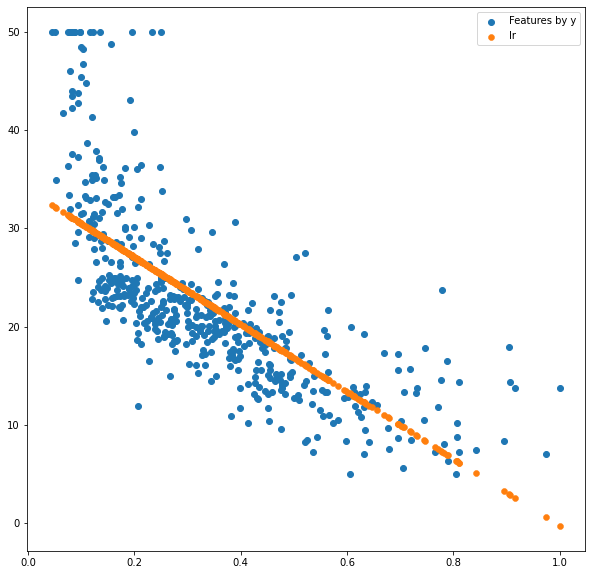

In [2]:
# Linear regression by torch

boston = load_boston()
x = torch.tensor(boston.data[::, 12] / boston.data[::, 12].max())
y = torch.tensor(boston.target)

w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

time.sleep(5)
for i in range(1000):

    y_pred = x * w + b

    loss = torch.mean((y_pred - torch.tensor(y))**2)
    loss.backward()

    w.data -= .05 * w.grad
    b.data -= .05 * b.grad

    w.grad.data.zero_()
    b.grad.data.zero_()

    w.requires_grad = True
    if i % 30 == 0:
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.scatter(x=x.data.numpy(), y=y.data.numpy(), label='Features by y')
        plt.scatter(x=x.data.numpy(),
                    y=y_pred.data.numpy(),
                    label='lr',
                    linewidth=0.5)
        plt.legend()
        plt.show()
    if loss < 0.1:
        print('1')
        break

In [3]:
# NN
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {"sample": torch.tensor(x[idx, :]), "target": y[idx]}


x = torch.rand(1000, 5)
y = torch.rand(1000)
dataset = Dataset(x, y)
dataset.__getitem__(1)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)
batch = next(iter(dataloader))

model = nn.Sequential()
model.add_module("l1", nn.Linear(5, 15))
model.add_module("l2", nn.ReLU())
model.add_module("l3", nn.Linear(15, 1))

another_model = nn.Sequential(nn.Linear(5, 15), nn.ReLU(), nn.Linear(15, 1))

<ipython-input-3-50521cf4410f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"sample": torch.tensor(x[idx, :]), "target": y[idx]}


In [4]:
batch = next(iter(dataloader))
print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

Sample:
tensor([[0.4009, 0.9734, 0.0065, 0.7461, 0.7094],
        [0.6963, 0.4320, 0.0296, 0.1595, 0.6428],
        [0.3992, 0.7435, 0.5709, 0.4253, 0.1278],
        [0.4470, 0.7344, 0.0043, 0.6418, 0.3207]])
Target:
tensor([0.3479, 0.8346, 0.9346, 0.3254])


<ipython-input-3-50521cf4410f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"sample": torch.tensor(x[idx, :]), "target": y[idx]}


In [5]:
y_pred = another_model(batch["sample"])
y_pred

tensor([[-0.3745],
        [-0.3106],
        [-0.2006],
        [-0.3443]], grad_fn=<AddmmBackward0>)

In [6]:
mnist_train = torchvision.datasets.MNIST(
    "./mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())

mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(mnist_train,
                                               batch_size=4,
                                               shuffle=True,
                                               num_workers=1)

val_dataloader = torch.utils.data.DataLoader(mnist_val,
                                             batch_size=4,
                                             shuffle=True,
                                             num_workers=1)

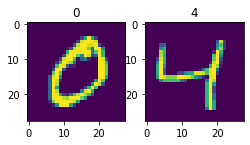

In [8]:
for i in [1, 2]:
    plt.subplot(1, 3, i+1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [9]:
# linear
model = nn.Sequential(
    nn.Flatten(),            # transform a picture 28x28 to tensor with shape == 784 
    nn.Linear(28*28, 128),   # linear layer for reshape vector from 784 to 128
    nn.ReLU(),               # nonlinear layer - max(0, x)
    nn.Linear(128, 10)       # linear layer for probability output
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

[x for x in model.named_parameters()]

[('1.weight',
  Parameter containing:
  tensor([[-0.0065, -0.0071, -0.0191,  ..., -0.0228, -0.0058, -0.0336],
          [ 0.0127,  0.0037, -0.0261,  ..., -0.0081, -0.0012,  0.0340],
          [-0.0069,  0.0091,  0.0259,  ...,  0.0246, -0.0207, -0.0078],
          ...,
          [ 0.0072, -0.0187,  0.0355,  ..., -0.0021, -0.0325,  0.0147],
          [-0.0340,  0.0138, -0.0131,  ..., -0.0087,  0.0228,  0.0349],
          [-0.0015, -0.0188,  0.0082,  ...,  0.0343,  0.0316, -0.0204]],
         requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([ 0.0244, -0.0051,  0.0101,  0.0095,  0.0130, -0.0195, -0.0227, -0.0035,
           0.0025, -0.0246,  0.0225,  0.0310,  0.0303, -0.0055,  0.0082, -0.0139,
           0.0144,  0.0310, -0.0095,  0.0162,  0.0143,  0.0195, -0.0012, -0.0150,
           0.0086,  0.0337,  0.0246,  0.0206, -0.0299, -0.0080, -0.0136,  0.0224,
           0.0288, -0.0266,  0.0348,  0.0018,  0.0273, -0.0300,  0.0286, -0.0133,
          -0.0205, -0.0224,  0.0092, 

In [10]:
import wandb

wandb.login()
wandb.init(project='mnist')
wandb.watch(model)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


[]

In [66]:
# сnn
model_with_normalization = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16, 32, 5, 1, 2),     
    nn.ReLU(),                      
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32 * 7 * 7, 10)
)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model_with_normalization.to('cuda')
    
optimizer = torch.optim.Adagrad(model_with_normalization.parameters(), lr=0.05)
wandb.watch(model_with_normalization)

[]

In [68]:
for epoch in range(15):
    for x_train, y_train in tqdm(train_dataloader):
        y_pred = model_with_normalization(x_train)
        loss = F.cross_entropy(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    if epoch % 2 == 0:
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                y_pred = model_with_normalization(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
                
        wandb.log({"mean val loss": np.mean(val_loss),
                  "mean val accuracy": np.mean(val_accuracy)}
                )
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 249.27it/s]


Epoch: 0, loss: 0.035570986568927765, accuracy: 0.9879


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 295.02it/s]


Epoch: 2, loss: 0.03420957177877426, accuracy: 0.9888


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 304.25it/s]


Epoch: 4, loss: 0.03375381603837013, accuracy: 0.9898


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 296.73it/s]


Epoch: 6, loss: 0.03526850417256355, accuracy: 0.989


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 312.93it/s]


Epoch: 8, loss: 0.03506936505436897, accuracy: 0.99


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 265.24it/s]


Epoch: 10, loss: 0.033467140048742294, accuracy: 0.99


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 278.81it/s]


Epoch: 12, loss: 0.03432309627532959, accuracy: 0.9897


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.15it/s]

Epoch: 14, loss: 0.03317314013838768, accuracy: 0.9898


In [82]:
print(np.argmax(model(x_val[3:4]).tolist()))

4


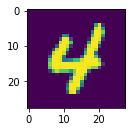

In [83]:
plt.subplot(1, 3, i+1)
plt.imshow(x_val[3:4][0].squeeze(0).numpy().reshape([28, 28]))

In [85]:
for i in range(len(x_val)):
    print(np.argmax(model(x_val[i]).tolist()), end='')
    print(np.argmax(model(x_val[i]).tolist()), end='')

34